In [76]:
import torch

def h_poly_helper(tt):
  A = torch.tensor([
      [1, 0, -3, 2],
      [0, 1, -2, 1],
      [0, 0, 3, -2],
      [0, 0, -1, 1]
      ], dtype=tt[-1].dtype)
  return [
    sum( A[i, j]*tt[j] for j in range(4) )
    for i in range(4) ]

def h_poly(t):
  tt = [ None for _ in range(4) ]
  tt[0] = 1
  for i in range(1, 4):
    tt[i] = tt[i-1]*t
  return h_poly_helper(tt)

def interp_func(x, y):
  "Returns integral of interpolating function"
  if len(y)>1:
    m = (y[1:] - y[:-1])/(x[1:] - x[:-1])
    m = torch.cat([m[[0]], (m[1:] + m[:-1])/2, m[[-1]]])
  def f(xs):
    if len(y)==1: # in the case of 1 point, treat as constant function
      return y[0] + torch.zeros_like(xs)
    I = torch.searchsorted(x[1:], xs)
    dx = (x[I+1]-x[I])
    hh = h_poly((xs-x[I])/dx)
    print(x)
    print(xs)
    print(I)
    print(dx)
    print(m)
    print(hh)
    print(hh[0]*y[I])
    return hh[0]*y[I] + hh[1]*m[I]*dx + hh[2]*y[I+1] + hh[3]*m[I+1]*dx
  return f

def interp(x, y, xs):
  return interp_func(x,y)(xs)

tensor([0.0000, 0.5000, 1.0000])
tensor([0.0000, 0.0204, 0.0408, 0.0612, 0.0816, 0.1020, 0.1224, 0.1429, 0.1633,
        0.1837, 0.2041, 0.2245, 0.2449, 0.2653, 0.2857, 0.3061, 0.3265, 0.3469,
        0.3673, 0.3878, 0.4082, 0.4286, 0.4490, 0.4694, 0.4898, 0.5102, 0.5306,
        0.5510, 0.5714, 0.5918, 0.6122, 0.6327, 0.6531, 0.6735, 0.6939, 0.7143,
        0.7347, 0.7551, 0.7755, 0.7959, 0.8163, 0.8367, 0.8571, 0.8776, 0.8980,
        0.9184, 0.9388, 0.9592, 0.9796, 1.0000])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1])
tensor([0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000,
        0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000,
        0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000,
        0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000,
        0.5000, 0.5000,

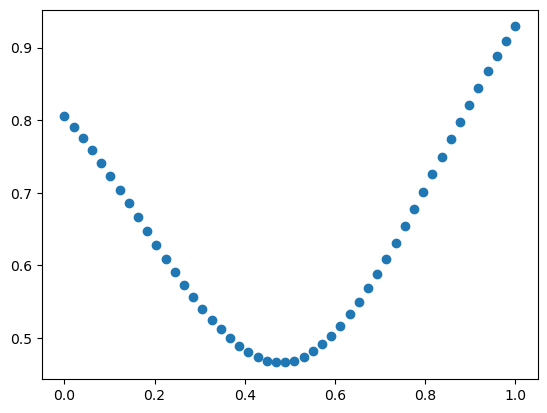

In [77]:
import matplotlib.pyplot as plt # for plotting
x = torch.rand(3)
u = torch.linspace(0, 1, 3)
us = torch.linspace(0, 1, 50)
xs = interp(u, x, us)
plt.plot(us, xs, 'o')

In [78]:
def cubic_spline_coff(u, x):
    a = x[:-1]
    du = u[1:] - u[:-1]
    dx = x[1:] - x[:-1]
    diff = dx / du

    m0 = torch.tensor([0])
    m1 = torch.tensor([6*(diff[1] - diff[0]) / 2 / (du[0] + du[1])])
    m2 = torch.tensor([0])
    m = torch.cat([m0, m1, m2])

    c = m / 2

    b0 = torch.tensor([diff[0] - du[0] * m[0] / 2 - du[0] * (m[1] - m[0]) / 6])
    b1 = torch.tensor([diff[1] - du[1] * m[1] / 2 - du[1] * (m[2] - m[1]) / 6])

    d0 = torch.tensor([(m[1] - m[0]) / 6 / du[0]])
    d1 = torch.tensor([(m[2] - m[1]) / 6 / du[1]])

    b = torch.cat([b0, b1])
    d = torch.cat([d0, d1])

    return a, b, c[:-1], d

In [79]:
coff = cubic_spline_coff(u, x)

In [80]:
coff

(tensor([0.8051, 0.4671]),
 tensor([-1.0761,  0.1239]),
 tensor([0.0000, 2.3999]),
 tensor([ 1.5999, -1.5999]))

In [81]:
def cubic_interp(coff, u, us):
    a, b, c, d = coff
    I = torch.searchsorted(u[1:], us)
    du = us - u[I]
    array = a[I] + b[I]*du + c[I]*torch.square(du) + d[I]*du**3

    return array
    

In [82]:
ys = cubic_interp(coff, u, us)

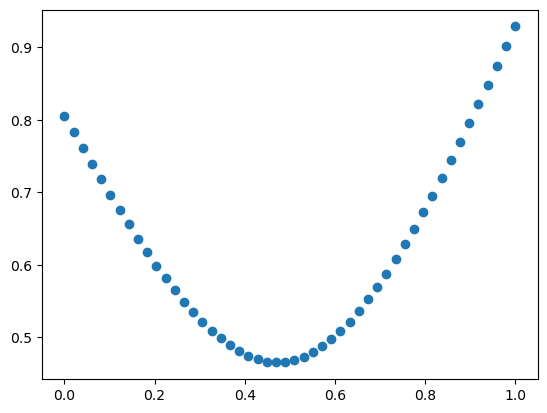

In [83]:
plt.plot(us, ys, 'o')

In [84]:
x_con = torch.rand(3).requires_grad_(True)

In [85]:
coff = cubic_spline_coff(u, x_con)
x_pre0 = cubic_interp(coff, u, us)

In [86]:
optimizer = torch.optim.Adam([x_con], lr=0.01)

In [87]:
def loss_fn(target, predict):
    return torch.norm(target - predict)

In [88]:
loss_array = []
pre_loss = 100
for i in range(1000):
    coff = cubic_spline_coff(u, x_con)
    x_pre = cubic_interp(coff, u, us)

    loss = loss_fn(x_pre, ys)
    loss.backward()
    print(x_con.grad)
    optimizer.step()
    optimizer.zero_grad()
    if abs(loss.detach() - pre_loss) < 0.0001:
        loss_array.append(loss.detach())
        break
    pre_loss = loss.detach()
    loss_array.append(pre_loss)

tensor([0.8551, 3.2560, 0.0000])
tensor([0.7285, 3.2386, 0.0000])
tensor([0.5975, 3.2180, 0.0000])
tensor([0.4627, 3.1942, 0.0000])
tensor([0.3248, 3.1670, 0.0000])
tensor([0.1852, 3.1365, 0.0000])
tensor([0.0454, 3.1030, 0.0000])
tensor([-0.0926,  3.0670,  0.0000])
tensor([-0.2264,  3.0290,  0.0000])
tensor([-0.3538,  2.9901,  0.0000])
tensor([-0.4731,  2.9509,  0.0000])
tensor([-0.5836,  2.9120,  0.0000])
tensor([-0.6856,  2.8737,  0.0000])
tensor([-0.7800,  2.8361,  0.0000])
tensor([-0.8681,  2.7990,  0.0000])
tensor([-0.9514,  2.7620,  0.0000])
tensor([-1.0311,  2.7247,  0.0000])
tensor([-1.1084,  2.6869,  0.0000])
tensor([-1.1842,  2.6482,  0.0000])
tensor([-1.2594,  2.6081,  0.0000])
tensor([-1.3345,  2.5665,  0.0000])
tensor([-1.4103,  2.5228,  0.0000])
tensor([-1.4873,  2.4768,  0.0000])
tensor([-1.5660,  2.4281,  0.0000])
tensor([-1.6468,  2.3762,  0.0000])
tensor([-1.7302,  2.3207,  0.0000])
tensor([-1.8167,  2.2610,  0.0000])
tensor([-1.9065,  2.1966,  0.0000])
tensor([-2.00

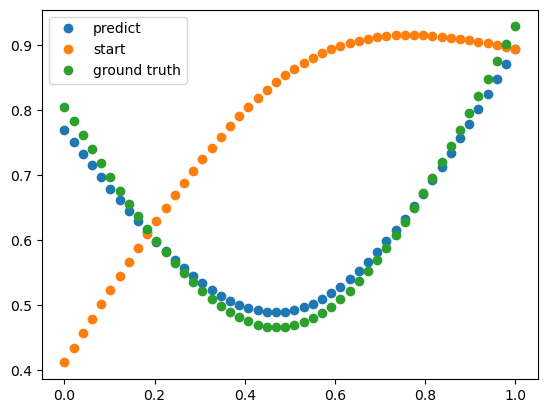

In [89]:
plt.plot(us, x_pre.detach(), 'o', label='predict')
plt.plot(us, x_pre0.detach(), 'o', label='start')
plt.plot(us, ys.detach(), 'o', label = 'ground truth')
plt.legend()

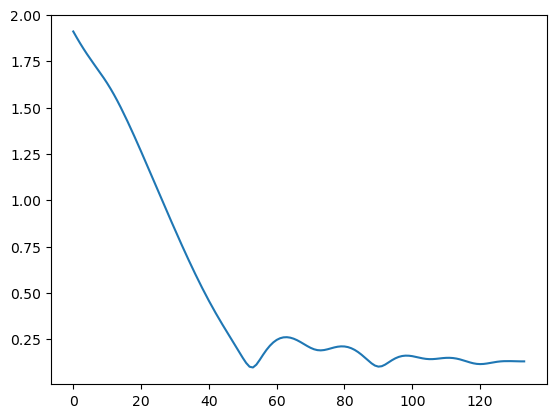

In [90]:
plt.plot(loss_array)